In [ ]:
# some imports before we start...
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sb
import scipy
import torch
# loading data
df = pd.read_csv("ccs2023_data.csv")
df

Motivating background data (generated in R):

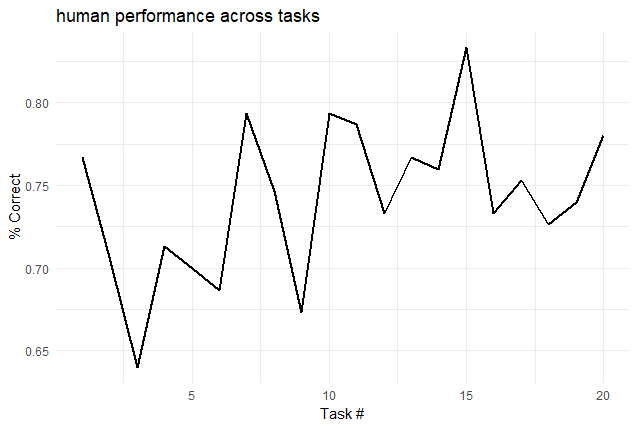

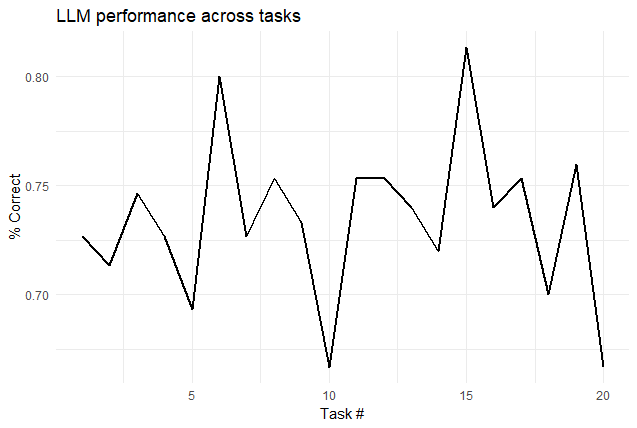

LLM/human learning: (generated in R: https://drive.google.com/file/d/1MDBRyh6Ju0vrWf7BGgYyxoqEQD3Tuu2i/view?usp=drive_link)
- Humans can learn faster in the first 3 or 4 trials
- LLMs can be more "optimal" at last
results of Gaussian process: https://drive.google.com/file/d/1BBREFLLiHKITrxoEEXtSi10ov7_HJalg/view?usp=drive_link

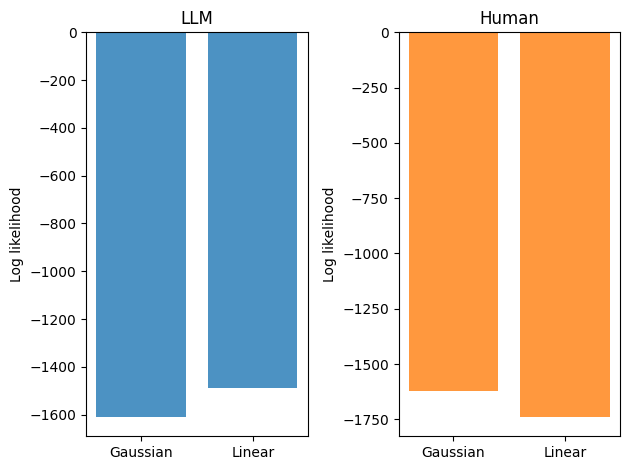

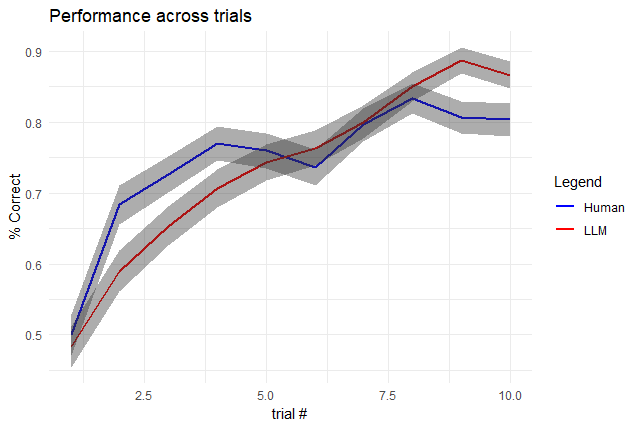

## Starting from the basics: Linear Regression



In [ ]:
df_llm = df[df['is_llm'] == 1]
df_non_llm = df[df['is_llm'] == 0]
#edit test by Tin

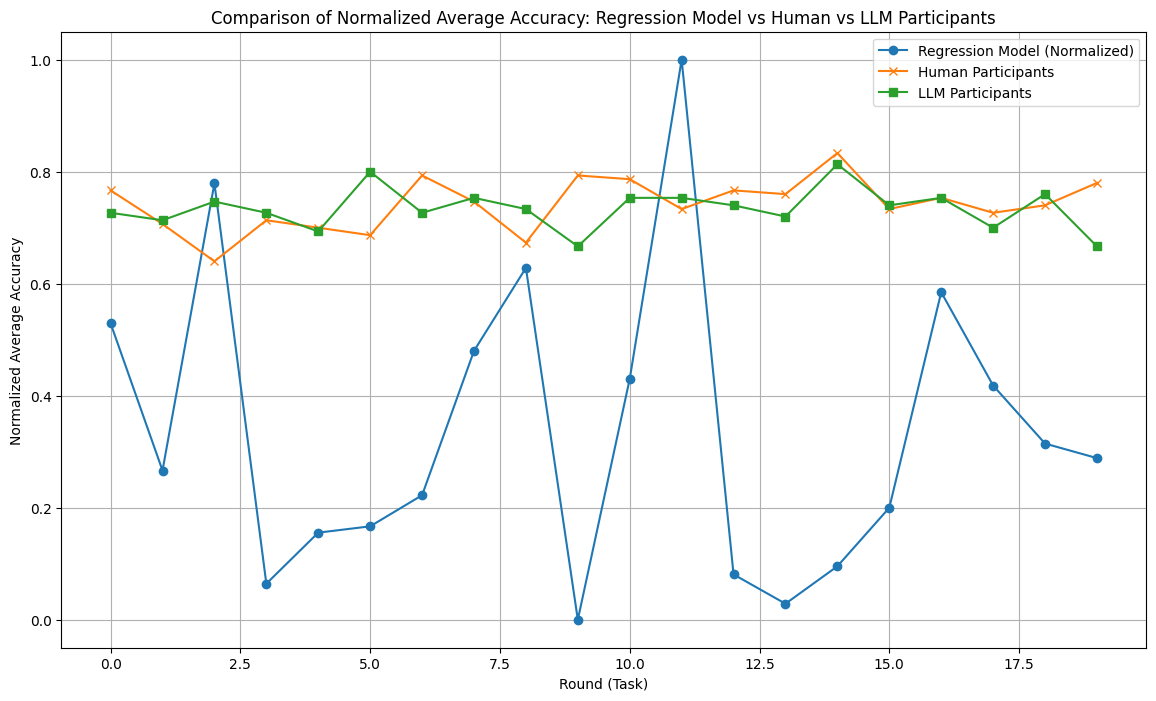

In [ ]:
from sklearn.linear_model import LinearRegression
import numpy as np
# Define unique tasks (rounds)
unique_tasks = df['task'].unique()

# Initialize variables to hold regression accuracies
regression_accuracies = []

# Loop through each task (round) for regression models
for task in unique_tasks:
    task_data = df[df['task'] == task]

    # Initialize variables to hold sum of squared errors for each output
    sum_squared_errors_f = 0
    sum_squared_errors_j = 0

    # Loop through each trial within this task
    unique_trials = task_data['trial'].unique()
    for trial in unique_trials:
        trial_data = task_data[task_data['trial'] == trial]

        # Extract features and outputs
        X_f = trial_data[['xf0', 'xf1']].values
        y_f = trial_data['yf'].values
        X_j = trial_data[['xj0', 'xj1']].values
        y_j = trial_data['yj'].values

        # Fit linear regression model
        model_f = LinearRegression()
        model_f.fit(X_f, y_f)
        model_j = LinearRegression()
        model_j.fit(X_j, y_j)

        # Make predictions
        y_pred_f = model_f.predict(X_f)
        y_pred_j = model_j.predict(X_j)

        # Calculate sum of squared errors for this trial
        sum_squared_errors_f += np.sum((y_f - y_pred_f)**2)
        sum_squared_errors_j += np.sum((y_j - y_pred_j)**2)

    # Calculate mean squared error for this task (round)
    mse_f = sum_squared_errors_f / len(unique_trials)
    mse_j = sum_squared_errors_j / len(unique_trials)

    # Calculate accuracy as 1 - mse (since mse is a loss, smaller is better)
    accuracy_f = 1 - mse_f
    accuracy_j = 1 - mse_j

    # Average accuracy for both outputs
    average_accuracy = (accuracy_f + accuracy_j) / 2

    # Append to list
    regression_accuracies.append({
        'task': task,
        'accuracy_f': accuracy_f,
        'accuracy_j': accuracy_j,
        'average_accuracy': average_accuracy
    })

# Convert to DataFrame for easier manipulation later
regression_accuracies_df = pd.DataFrame(regression_accuracies)

human_accuracies = []
llm_accuracies = []

for task in unique_tasks:
    task_data = df[df['task'] == task]

    human_data = task_data[task_data['is_llm'] == 0]
    llm_data = task_data[task_data['is_llm'] == 1]

    #average accuracy for human participants
    total_human_trials = len(human_data)
    correct_human_trials = len(human_data[human_data['J_wins'] == human_data['J_pressed']])
    human_accuracy = correct_human_trials / total_human_trials if total_human_trials > 0 else None

    # average accuracy for LLM participants
    total_llm_trials = len(llm_data)
    correct_llm_trials = len(llm_data[llm_data['J_wins'] == llm_data['J_pressed']])
    llm_accuracy = correct_llm_trials / total_llm_trials if total_llm_trials > 0 else None

    human_accuracies.append({'task': task, 'average_accuracy': human_accuracy})
    llm_accuracies.append({'task': task, 'average_accuracy': llm_accuracy})

human_accuracies_df = pd.DataFrame(human_accuracies)
llm_accuracies_df = pd.DataFrame(llm_accuracies)

# Normalize the regression model
min_mse = min(regression_accuracies_df['average_accuracy'])
max_mse = max(regression_accuracies_df['average_accuracy'])
scaled_regression_avg_acc = (regression_accuracies_df['average_accuracy'] - min_mse) / (max_mse - min_mse)
normalized_regression_avg_acc = 1 - scaled_regression_avg_acc

#plotting
tasks = regression_accuracies_df['task']


plt.figure(figsize=(14, 8))
plt.plot(tasks, normalized_regression_avg_acc, label='Regression Model (Normalized)', marker='o')
plt.plot(tasks, human_accuracies_df['average_accuracy'], label='Human Participants', marker='x')
plt.plot(tasks, llm_accuracies_df['average_accuracy'], label='LLM Participants', marker='s')
plt.xlabel('Round (Task)')
plt.ylabel('Normalized Average Accuracy')
plt.title('Comparison of Normalized Average Accuracy: Regression Model vs Human vs LLM Participants')
plt.legend()
plt.grid(True)
plt.show()


In [ ]:
#Overall average accuracy for LR :
acc = sum(normalized_regression_avg_acc)/len(normalized_regression_avg_acc)
print(acc)

0.33666534986471247


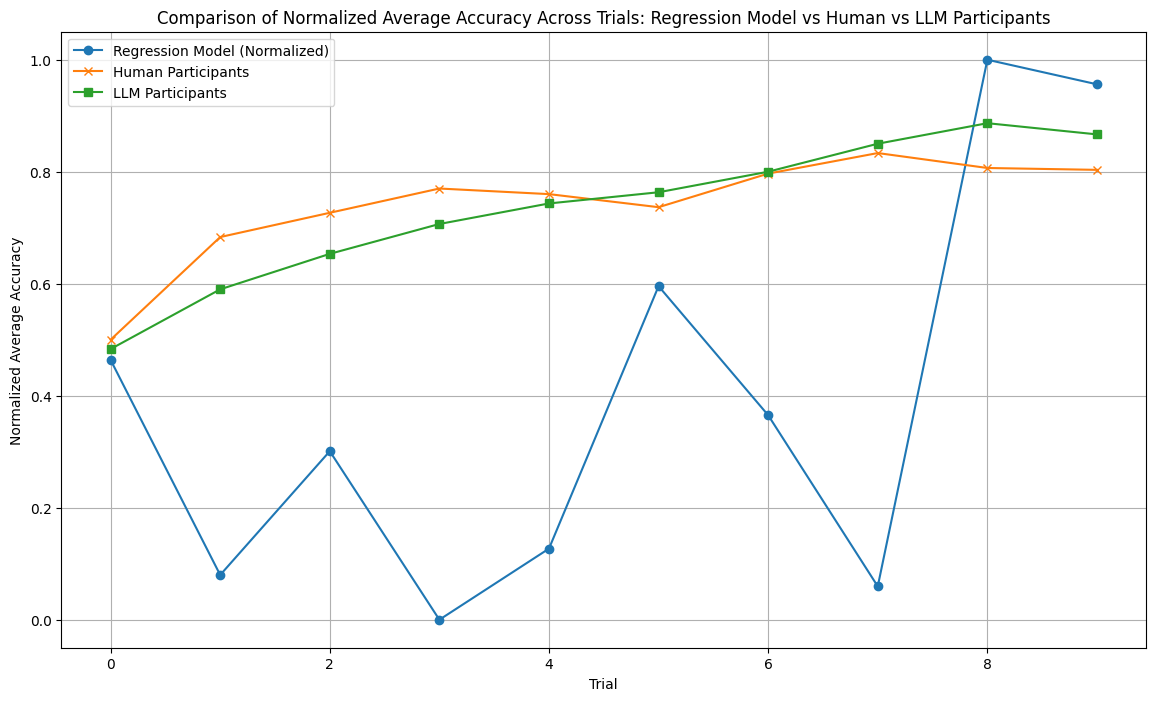

In [ ]:
#and then linear regression across trials
unique_trials = df['trial'].unique()

# Initialize variables to hold trial-based accuracies
trial_based_regression_accuracies = []
trial_based_human_accuracies = []
trial_based_llm_accuracies = []

# Loop through each unique trial for regression models, human and LLM participants
for trial in unique_trials:
    trial_data = df[df['trial'] == trial]

    sum_squared_errors_f = np.sum((trial_data['yf'] - (trial_data['w0']*trial_data['xf0'] + trial_data['w1']*trial_data['xf1']))**2)
    sum_squared_errors_j = np.sum((trial_data['yj'] - (trial_data['w0']*trial_data['xj0'] + trial_data['w1']*trial_data['xj1']))**2)
    mse_f = sum_squared_errors_f / len(unique_trials)
    mse_j = sum_squared_errors_j / len(unique_trials)
    accuracy_f = 1 - mse_f
    accuracy_j = 1 - mse_j
    average_accuracy = (accuracy_f + accuracy_j) / 2
    trial_based_regression_accuracies.append({'trial': trial, 'average_accuracy': average_accuracy})

    #Human Participants
    human_data = trial_data[trial_data['is_llm'] == 0]
    total_human_trials = len(human_data)
    correct_human_trials = len(human_data[human_data['J_wins'] == human_data['J_pressed']])
    human_accuracy = correct_human_trials / total_human_trials if total_human_trials > 0 else None
    trial_based_human_accuracies.append({'trial': trial, 'average_accuracy': human_accuracy})

    #LLM Participants
    llm_data = trial_data[trial_data['is_llm'] == 1]
    total_llm_trials = len(llm_data)
    correct_llm_trials = len(llm_data[llm_data['J_wins'] == llm_data['J_pressed']])
    llm_accuracy = correct_llm_trials / total_llm_trials if total_llm_trials > 0 else None
    trial_based_llm_accuracies.append({'trial': trial, 'average_accuracy': llm_accuracy})

trial_based_regression_accuracies_df = pd.DataFrame(trial_based_regression_accuracies)
trial_based_human_accuracies_df = pd.DataFrame(trial_based_human_accuracies)
trial_based_llm_accuracies_df = pd.DataFrame(trial_based_llm_accuracies)

#normalize
min_mse = min(trial_based_regression_accuracies_df['average_accuracy'])
max_mse = max(trial_based_regression_accuracies_df['average_accuracy'])
scaled_trial_based_regression_avg_acc = (trial_based_regression_accuracies_df['average_accuracy'] - min_mse) / (max_mse - min_mse)
normalized_trial_based_regression_avg_acc = 1 - scaled_trial_based_regression_avg_acc

plt.figure(figsize=(14, 8))
plt.plot(unique_trials, normalized_trial_based_regression_avg_acc, label='Regression Model (Normalized)', marker='o')
plt.plot(unique_trials, trial_based_human_accuracies_df['average_accuracy'], label='Human Participants', marker='x')
plt.plot(unique_trials, trial_based_llm_accuracies_df['average_accuracy'], label='LLM Participants', marker='s')
plt.xlabel('Trial')
plt.ylabel('Normalized Average Accuracy')
plt.title('Comparison of Normalized Average Accuracy Across Trials: Regression Model vs Human vs LLM Participants')
plt.legend()
plt.grid(True)
plt.show()


## Defining the environment (see IICCSSS notebooks for rules)

In [ ]:
def simulate_participant(agent, environment, participant=0):
    actions = []
    correct_actions = []

    for planet in range(n_planets): # loop over planets
        # environment: sample true weights for planet
        true_weights = environment.sample_weights(participant, planet)

        # reset the agent: to discard knowledge from the previous planet
        agent.reset()

        for trial in range(n_trials_per_planet): # loop over trials
            # environment: sample input values for trial
            xF, xJ = environment.sample_inputs(participant, planet, trial)

            # agent: make choice
            yF_estimate, yJ_estimate = agent.predict(xF, xJ)
            action = 0 if yF_estimate > yJ_estimate else 1 # select the winner (greedily)
            actions += [action] # append the action to a list

            # environment: compute feedback
            yF = xF @ true_weights
            yJ = xJ @ true_weights
            correct_action = 0 if yF > yJ else 1
            correct_actions += [correct_action]

            # agent: learn from that feedback
            agent.update(trial, xF, xJ, yF, yJ)

    return np.array(actions), np.array(correct_actions)

In [ ]:
def simulate_all_participants(agent, environment, n_participants=30):
    actions_all = []
    correct_actions_all = []
    for participant in range(n_participants):
        actions, correct_actions = simulate_participant(agent, environment, participant)
        actions_all += [actions]
        correct_actions_all += [correct_actions]
    return np.array(actions_all).flatten(), np.array(correct_actions_all).flatten()


In [ ]:
class DataEnvironment():
    """
    This environment can be used to repeat the real data of the participants.
    Weights and inputs are not sampled again, but we look them up in the data
    for a given participant, planet and trial.
    """
    def __init__(self):
        # loading data
        self.df = pd.read_csv("ccs2023_data.csv")

    def sample_weights(self, participant, planet):
        df = self.df
        row = df[(df["participant"] == participant) & (df["task"] == planet)].iloc[0]
        return np.array([row["w0"], row["w1"]])[:,np.newaxis]

    def sample_inputs(self, participant, planet, trial):
        df = self.df
        row = df[(df["participant"] == participant) & (df["task"] == planet) & (df["trial"] == trial)]
        return np.array([row["xf0"], row["xf1"]]).T, \
               np.array([row["xj0"], row["xj1"]]).T


In [ ]:
# just define some constants
n_planets = 20
n_trials_per_planet = 10
n_participants = 30

In [ ]:
class OptimalAgent():
    def __init__(self):
        self.w = np.zeros([2,1])

    def reset(self):
        """
        Reset the internal model (here: weights).
        Call this after each planet!
        """
        self.w = np.zeros([2,1])

    def predict(self, xF, xJ):
        """
        Predict the y values.
        """
        yF_estimated = xF @ self.w
        yJ_estimated = xJ @ self.w
        return yF_estimated, yJ_estimated

    def update(self, trial, xF, xJ, yF, yJ):
        """
        Update the internal model.
        """
        if trial == 0: # only after the first trial we have to learn
            X = np.vstack([xF, xJ])
            y = np.vstack([yF, yJ])
            self.w = np.linalg.solve(X, y) # this linear equation solver does all the hard work

In [ ]:
agent = OptimalAgent()
environment = DataEnvironment()
actions_all, _ = simulate_all_participants(agent, environment)

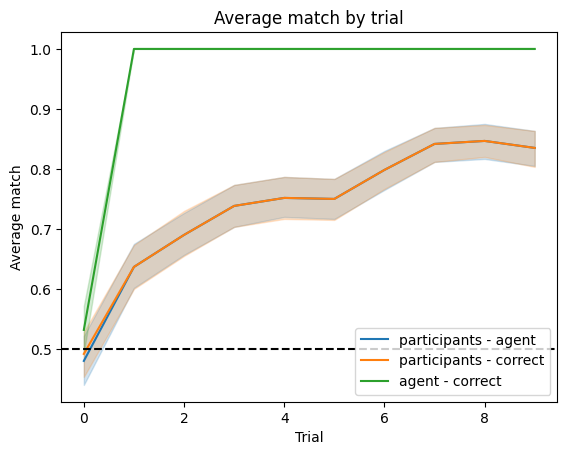

In [ ]:
# we can also plot the match over trials (averaging over planets and participants)
# hypothesis: in later trials participants should become more optimal

#plotting the optimal agent
def plot_match_by_trial(df, actions_all):
    # join the simulated data with the participant data frame
    df["J_pressed_agent"] = actions_all
    df["match_participant_agent"] = df["J_pressed"] == df["J_pressed_agent"]
    df["match_participant_correct"] = df["J_pressed"] == df["J_wins"]
    df["match_agent_correct"] = df["J_pressed_agent"] == df["J_wins"]
    sb.lineplot(df, x="trial", y="match_participant_agent", label="participants - agent")
    sb.lineplot(df, x="trial", y="match_participant_correct", label="participants - correct")
    sb.lineplot(df, x="trial", y="match_agent_correct", label="agent - correct")
    plt.axhline(y=0.5, linestyle="--", c="k")
    plt.title("Average match by trial")
    plt.ylabel("Average match")
    plt.xlabel("Trial")
    plt.show()

plot_match_by_trial(df, actions_all)

# Rule-Based Model
Starts from the intuition of our own play :
- prioritize features first look at one feature, and if there is large - difference favoring one monster, choose the monster.
- If there is no big difference, see the next feature
- How to learn?: if made mistakes, change its prioritized features, and randomly reset if the smaller or the larger feature is favorable

In [ ]:

#improving on intuition: rule-based modeling
class RuleBasedAgent1():
    def __init__(self, threshold=.05):
        self.threshold = threshold
        self.tgt = np.random.choice([0, 1])
        self.signs = np.random.choice([1, -1], 2)

    def reset(self):
        self.tgt = np.random.choice([0, 1])
        self.signs = np.random.choice([1, -1], 2)

    def predict(self, xF, xJ):
        tgt_delta = (xF[0][self.tgt] - xJ[0][self.tgt]) * self.signs[self.tgt]
        if tgt_delta > self.threshold:
            self.yF_estim, self.yJ_estim = 1, 0
        elif tgt_delta < -self.threshold:
            self.yF_estim, self.yJ_estim = 0, 1
        else:
            tgt_delta = (xF[0][1-self.tgt] - xJ[0][1-self.tgt]) * self.signs[1-self.tgt]
            if tgt_delta > self.threshold:
                self.yF_estim, self.yJ_estim = 1, 0
            elif tgt_delta < -self.threshold:
                self.yF_estim, self.yJ_estim = 0, 1
            else:
                self.yF_estim, self.yJ_estim = 0, 0
        return self.yF_estim, self.yJ_estim

    def update(self, trial, xF, xJ, yF, yJ):
        was_correct = (yF > yJ) == (self.yF_estim > self.yJ_estim)
        if not was_correct:
            self.signs[self.tgt] = 1 - self.signs[self.tgt]
            self.tgt = 1 - self.tgt
def plot_match_by_participant(df, actions_all, n_participants=30):
    # join the simulated data with the participant data frame
    df["J_pressed_agent"] = actions_all
    df["match_agent"] = df["J_pressed_agent"] == df["J_pressed"]
    match_per_participant = df.groupby("participant").agg({"match_agent": np.mean}).to_numpy().flatten()
    plt.bar(range(n_participants), match_per_participant)
    plt.axhline(y=0.5, linestyle="--", c="k")
    plt.legend(["chance"])
    plt.title("Average match with agent by participant")
    plt.ylabel("Average match")
    plt.xlabel("Participant")
    plt.show()



agent = RuleBasedAgent1()
environment = DataEnvironment()

actions, correct_actions = simulate_all_participants(agent, environment)

#plot_match_by_participant(df, actions)
plot_match_by_trial(df, actions)

# Self-Orienting Map
SOM: an ANN trained using competitive learning.
- Strong biological inspiration
- Unsupervised clustering; we picked this model because it selects well for - low-dimensional datasets, projecting onto 2D map of proximal clusters and uses a ‘winner-takes-all’ neuron selection process
- The goal of learning in the SOM is to cause different parts of the network to respond similarly to different, repeated stimuli

In [ ]:
#SOM: self-orienting map model
import pandas as pd
import numpy as np

df = pd.read_csv('ccs2023_data.csv')

filtered_df = df[['trial', 'w0', 'w1', 'xf0', 'xf1', 'yf', 'yj', 'is_llm']]

# Initialize the SOM grid with random weights (10x10 grid, 4 weights for w0, w1, xf0, xf1)
grid_dim_x = 10
grid_dim_y = 10
som_grid = np.random.rand(grid_dim_x, grid_dim_y, 4)



In [ ]:
def update_weights(winning_neuron, data_point, output_value, learning_rate, radius):
    global som_grid
    x, y = winning_neuron
    for i in range(max(0, x - radius), min(grid_dim_x, x + radius + 1)):
        for j in range(max(0, y - radius), min(grid_dim_y, y + radius + 1)):
            #  distance to the winning neuron
            distance = euclidean_distance(np.array([x, y]), np.array([i, j]))
            if distance <= radius:
                # Update the weights based on the higher output value (yf or yj)
                som_grid[i, j, :] += learning_rate * (data_point - som_grid[i, j, :]) * output_value

learning_rate = 0.5
radius = 2

#averaging over trials
unique_rounds = filtered_df['trial'].unique()

for rnd in unique_rounds:
    round_data = filtered_df[filtered_df['trial'] == rnd]

    for idx, row in round_data.iterrows():
        data_point = np.array([row['w0'], row['w1'], row['xf0'], row['xf1']])
        higher_output_value = max(row['yf'], row['yj'])

        #Euclidean distance between data_point and all neurons
        distances = np.linalg.norm(som_grid - data_point, axis=2)

        #get the "winning" neuron (smallest distance)
        winning_neuron = np.unravel_index(np.argmin(distances), distances.shape)

        # update weights of the winning neuron and its neighbors
        update_weights(winning_neuron, data_point, higher_output_value, learning_rate, radius)

# Show the first 2x2 corner of the grid after training for verification
som_grid[:2, :2, :]


In [ ]:
def euclidean_distance(v1, v2):
    return np.linalg.norm(v1 - v2)

# Retry training the SOM
for rnd in unique_rounds:
    # Filter data for the current round
    round_data = filtered_df[filtered_df['trial'] == rnd]

    # Iterate through each data point in the round
    for idx, row in round_data.iterrows():
        data_point = np.array([row['w0'], row['w1'], row['xf0'], row['xf1']])
        higher_output_value = max(row['yf'], row['yj'])

        distances = np.linalg.norm(som_grid - data_point, axis=2)

        winning_neuron = np.unravel_index(np.argmin(distances), distances.shape)

        update_weights(winning_neuron, data_point, higher_output_value, learning_rate, radius)

# Show the first 2x2 corner of the grid after training for verification
som_grid[:2, :2, :]


array([[[-1.81489293,  1.83439961, -4.90567438,  3.10735436],
        [-1.81183416,  2.45040794,  1.89347759, -0.4827762 ]],

       [[-1.06474509,  2.00011971, -0.67704538,  0.06232396],
        [-2.44606137,  2.97386143, -0.39236153,  0.15080838]]])

In [ ]:
#store SOM predictions
som_predictions = []

# Make predictions using the trained SOM for each round
for rnd in unique_rounds:
    # Filter data for the current round
    round_data = filtered_df[filtered_df['trial'] == rnd]

    # Iterate through each data point in the round
    for idx, row in round_data.iterrows():
        data_point = np.array([row['w0'], row['w1'], row['xf0'], row['xf1']])

        distances = np.linalg.norm(som_grid - data_point, axis=2)
        winning_neuron = np.unravel_index(np.argmin(distances), distances.shape)

        winning_weights = som_grid[winning_neuron]
        som_prediction = np.dot(winning_weights, data_point)
        som_predictions.append(som_prediction)

# Add the SOM predictions to the filtered DataFrame
filtered_df['som_predictions'] = som_predictions

# Show the first few rows of the DataFrame for verification
filtered_df.head()


<ipython-input-20-a71ae24381df>:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_df['som_predictions'] = som_predictions


,trial,w0,w1,xf0,xf1,yf,yj,is_llm,som_predictions
0,0,-0.696263,-0.699151,1.106486,-0.704793,-0.277650,-0.526670,1,3.639702
1,1,-0.696263,-0.699151,-0.489473,0.844319,-0.249504,0.114588,1,1.472096
2,2,-0.696263,-0.699151,-1.276077,-0.305100,1.101796,1.887954,1,4.814763
3,3,-0.696263,-0.699151,1.501713,-0.201051,-0.905022,-0.300708,1,2.306091
4,4,-0.696263,-0.699151,-0.230728,-0.697054,0.647993,0.060549,1,3.130872


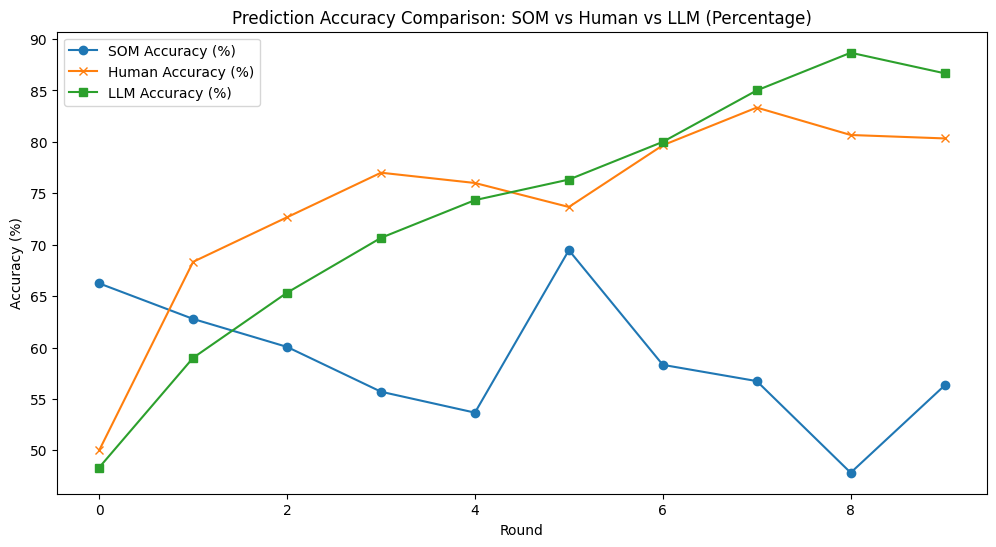

In [ ]:
# Initialize lists to store percentage accuracy values
som_accuracies_percent = []
human_accuracies_percent = []
llm_accuracies_percent = []

# Calculate percentage prediction accuracies for each round
for rnd in unique_rounds:
    # Filter data for the current round
    round_data = filtered_df[filtered_df['trial'] == rnd]

    # Maximum possible difference for the current round
    max_possible_diff = round_data[['yf', 'yj']].max().max()

    # Calculate accuracy for SOM
    som_accuracy = np.mean(np.abs(round_data['som_predictions'] - round_data[['yf', 'yj']].max(axis=1)))
    som_accuracy_percent = (1 - (som_accuracy / max_possible_diff)) * 100
    som_accuracies_percent.append(som_accuracy_percent)

    # Calculate accuracy for human participants
    human_data = round_data[round_data['is_llm'] == 0]
    human_accuracy = np.mean(np.abs(human_data['yf'] - human_data[['yf', 'yj']].max(axis=1)))
    human_accuracy_percent = (1 - (human_accuracy / max_possible_diff)) * 100
    human_accuracies_percent.append(human_accuracy_percent)

    # Calculate accuracy for LLM participants
    llm_data = round_data[round_data['is_llm'] == 1]
    llm_accuracy = np.mean(np.abs(llm_data['yf'] - llm_data[['yf', 'yj']].max(axis=1)))
    llm_accuracy_percent = (1 - (llm_accuracy / max_possible_diff)) * 100
    llm_accuracies_percent.append(llm_accuracy_percent)

# Visualize the comparison in percentage terms
plt.figure(figsize=(12, 6))
plt.plot(unique_rounds, som_accuracies_percent, label='SOM Accuracy (%)', marker='o')
plt.plot(unique_rounds, list(100*trial_based_human_accuracies_df['average_accuracy']), label='Human Accuracy (%)', marker='x')
plt.plot(unique_rounds, list(100*trial_based_llm_accuracies_df['average_accuracy']), label='LLM Accuracy (%)', marker='s')
plt.xlabel('Round')
plt.ylabel('Accuracy (%)')
plt.title('Prediction Accuracy Comparison: SOM vs Human vs LLM (Percentage)')
plt.legend()
plt.show()


In [ ]:
acc_som = sum(som_accuracies_percent)/len(som_accuracies_percent)
print(acc_som)
#SOM average accuracy

59.151371391718044


In [ ]:
list(trial_based_human_accuracies_df['average_accuracy'])

[0.5,
 0.6833333333333333,
 0.7266666666666667,
 0.77,
 0.76,
 0.7366666666666667,
 0.7966666666666666,
 0.8333333333333334,
 0.8066666666666666,
 0.8033333333333333]